In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras.models import save_model
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-6b682b51bcc0>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data=pd.read_excel(r"../SAMSUNG/Me.xlsx")

In [3]:
furniture= data.groupby('Order Date')['Quantity'].sum().reset_index()
furniture

,Order Date,Quantity
0,2014-01-06,9
1,2014-01-07,3
2,2014-01-10,1
3,2014-01-11,2
4,2014-01-13,9
...,...,...
1983,2020-12-27,13
1984,2020-12-28,4
1985,2020-12-29,98
1986,2020-12-30,68


In [4]:
furniture = data.set_index('Order Date')

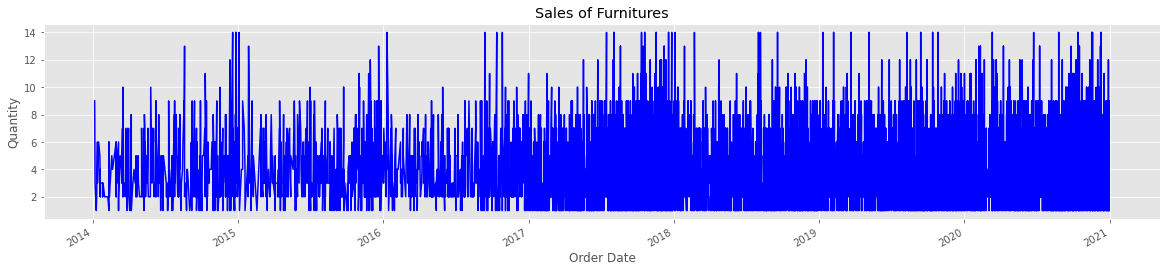

In [5]:
ax= furniture['Quantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Order Date")
ax.set_ylabel('Quantity')
ax.set_title("Sales of Furnitures")
plt.show()

In [6]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [17]:
df = furniture['Quantity'].resample('MS').sum()

In [18]:
df

Order Date
2014-01-01      70
2014-02-01      23
2014-03-01     131
2014-04-01      81
2014-05-01      97
              ... 
2020-08-01     888
2020-09-01    1193
2020-10-01    1020
2020-11-01    1206
2020-12-01    1310
Freq: MS, Name: Quantity, Length: 84, dtype: int64

In [19]:
train, test = np.array(df[:-18]), np.array(df[-18:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [20]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [21]:
n_input = 18
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [31]:
######
#set the counter to repeat
n=3
store= np.zeros((18,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(100, activation='relu', input_shape=(18, 1)))
    #Add layer
    model_vanilla.add(Dense(150, activation='relu'))
    model_vanilla.add(Dense(150, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Epoch 1/200
5/5 [==============================] - 2s 13ms/step - loss: 0.1391
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1010
Epoch 3/200
5/5 [==============================] - 0s 9ms/step - loss: 0.0441
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0276
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0394
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0351
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0359
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0324
Epoch 9/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0300
Epoch 10/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0314
Epoch 11/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0312
Epoch 12/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0288
Epoch 13/200
5/5 [==============================] 

5/5 [==============================] - 0s 25ms/step - loss: 0.0367
Epoch 5/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0354
Epoch 6/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0329
Epoch 7/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0349
Epoch 8/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0320
Epoch 9/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0298
Epoch 10/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0345
Epoch 11/200
5/5 [==============================] - 0s 26ms/step - loss: 0.0292
Epoch 12/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0310
Epoch 13/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0297
Epoch 14/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0277
Epoch 15/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0277
Epoch 16/200
5/5 [==============================] - 0s 12m

5/5 [==============================] - 0s 26ms/step - loss: 0.0372
Epoch 8/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0343
Epoch 9/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0295
Epoch 10/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0344
Epoch 11/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0332
Epoch 12/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0295
Epoch 13/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0296
Epoch 14/200
5/5 [==============================] - 0s 24ms/step - loss: 0.0302
Epoch 15/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0283
Epoch 16/200
5/5 [==============================] - 0s 28ms/step - loss: 0.0293
Epoch 17/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0289
Epoch 18/200
5/5 [==============================] - 0s 25ms/step - loss: 0.0265
Epoch 19/200
5/5 [==============================] - 0s 

In [32]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((18,))

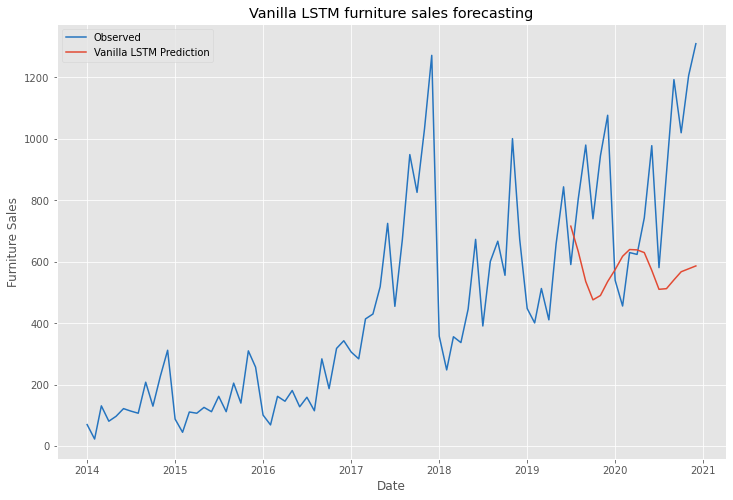

In [33]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[66:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [34]:
data1=pd.read_csv(r"../SAMSUNG/Seo_test3round.csv")

In [35]:
furniture1= data1.groupby('Order Date')['Quantity'].sum().reset_index()
furniture1

,Order Date,Quantity
0,2014-01-11,2
1,2014-01-13,0
2,2014-01-20,3
3,2014-01-21,2
4,2014-01-26,3
...,...,...
520,2020-12-18,0
521,2020-12-20,3
522,2020-12-24,4
523,2020-12-29,5


In [36]:
furniture1 = furniture1.set_index('Order Date')

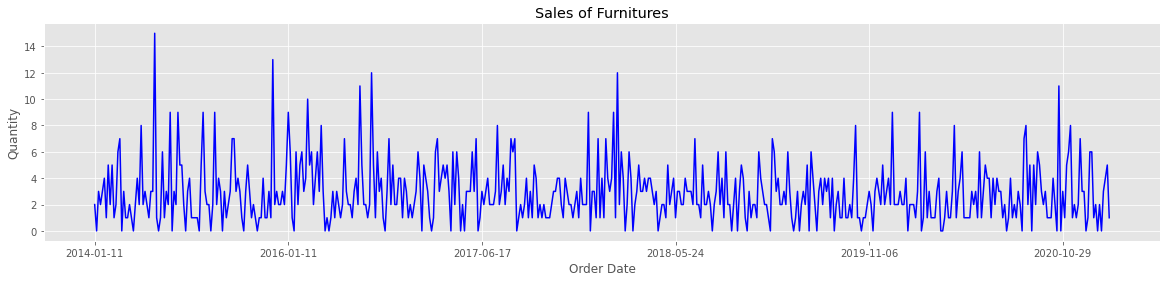

In [37]:
ax= furniture1['Quantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Order Date")
ax.set_ylabel('Quantity')
ax.set_title("Sales of Furnitures")
plt.show()

In [38]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [40]:
furniture1.index

Index(['2014-01-11', '2014-01-13', '2014-01-20', '2014-01-21', '2014-01-26',
       '2014-03-11', '2014-03-15', '2014-03-19', '2014-03-21', '2014-03-25',
       ...
       '2020-12-05', '2020-12-06', '2020-12-08', '2020-12-09', '2020-12-17',
       '2020-12-18', '2020-12-20', '2020-12-24', '2020-12-29', '2020-12-30'],
      dtype='object', name='Order Date', length=525)

In [42]:
furniture1.index = pd.to_datetime(furniture1.index)
df1 = furniture1['Quantity'].resample('MS').sum()

In [43]:
df1

Order Date
2014-01-01    10
2014-02-01     0
2014-03-01    17
2014-04-01     3
2014-05-01    13
              ..
2020-08-01    21
2020-09-01    42
2020-10-01    28
2020-11-01    33
2020-12-01    31
Freq: MS, Name: Quantity, Length: 84, dtype: int64

In [56]:
train, test = np.array(df1[:-24]), np.array(df1[-24:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [57]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [58]:
n_input = 24
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [59]:
######
#set the counter to repeat
n=3
store= np.zeros((24,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(100, activation='relu', input_shape=(24, 1)))
    #Add layer
    model_vanilla.add(Dense(150, activation='relu'))
    model_vanilla.add(Dense(150, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)
    
    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list.append(model_vanilla.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Epoch 1/200
4/4 [==============================] - 2s 34ms/step - loss: 0.1252
Epoch 2/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0889
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0565
Epoch 4/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0535
Epoch 5/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0508
Epoch 6/200
4/4 [==============================] - 0s 31ms/step - loss: 0.0463
Epoch 7/200
4/4 [==============================] - 0s 19ms/step - loss: 0.0485
Epoch 8/200
4/4 [==============================] - 0s 19ms/step - loss: 0.0485
Epoch 9/200
4/4 [==============================] - 0s 19ms/step - loss: 0.0469
Epoch 10/200
4/4 [==============================] - 0s 33ms/step - loss: 0.0468
Epoch 11/200
4/4 [==============================] - 0s 35ms/step - loss: 0.0464
Epoch 12/200
4/4 [==============================] - 0s 33ms/step - loss: 0.0463
Epoch 13/200
4/4 [==============================]

4/4 [==============================] - 0s 12ms/step - loss: 0.0520
Epoch 5/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0468
Epoch 6/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0477
Epoch 7/200
4/4 [==============================] - 0s 23ms/step - loss: 0.0485
Epoch 8/200
4/4 [==============================] - 0s 24ms/step - loss: 0.0470
Epoch 9/200
4/4 [==============================] - 0s 12ms/step - loss: 0.0460
Epoch 10/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0462
Epoch 11/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0462
Epoch 12/200
4/4 [==============================] - 0s 29ms/step - loss: 0.0460
Epoch 13/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0462
Epoch 14/200
4/4 [==============================] - 0s 34ms/step - loss: 0.0463
Epoch 15/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0459
Epoch 16/200
4/4 [==============================] - 0s 10m

4/4 [==============================] - 0s 24ms/step - loss: 0.0479
Epoch 8/200
4/4 [==============================] - 0s 37ms/step - loss: 0.0467
Epoch 9/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0467
Epoch 10/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0463
Epoch 11/200
4/4 [==============================] - 0s 34ms/step - loss: 0.0462
Epoch 12/200
4/4 [==============================] - 0s 36ms/step - loss: 0.0459
Epoch 13/200
4/4 [==============================] - 0s 36ms/step - loss: 0.0459
Epoch 14/200
4/4 [==============================] - 0s 36ms/step - loss: 0.0462
Epoch 15/200
4/4 [==============================] - 0s 32ms/step - loss: 0.0461
Epoch 16/200
4/4 [==============================] - 0s 34ms/step - loss: 0.0459
Epoch 17/200
4/4 [==============================] - 0s 35ms/step - loss: 0.0457
Epoch 18/200
4/4 [==============================] - 0s 37ms/step - loss: 0.0458
Epoch 19/200
4/4 [==============================] - 0s 

In [60]:
final_vanilla= np.zeros((store.shape[0],1))

#final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):
    
    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((24,))

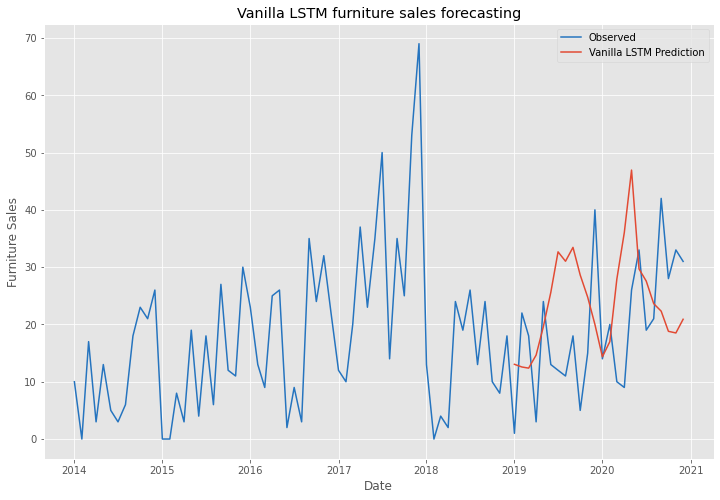

In [62]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df1.index,df1,label="Observed",color='#2574BF')
plt.plot(df1[60:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [1]:
vanilla_lstm= performance(df[-18:],final_vanilla)
vanilla_lstm # 마지막에 다시 돌려보기

NameError: name 'performance' is not defined